# 👩🏼‍🚒 Training a Rockpool network with Torch

In [1]:
# -- Some useful imports

# - Rich printinghttp://localhost:8888/notebooks/torch-training.ipynb#
try:
    from rich import print
except:
    pass

# - Numpy
import numpy as np

# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## Considerations when using Torch

## Define a task

In [2]:
import torch

# - Define a dataset class implementing the indexing interface
class MultiClassRandomSinMapping:
    def __init__(self,
                 num_classes: int = 2,
                 sample_length: int = 100,
                 input_channels: int = 50,
                 target_channels: int = 2):
        # - Record task parameters
        self._num_classes = num_classes
        self._sample_length = sample_length
        
        # - Draw random input signals
        self._inputs = np.random.randn(num_classes, sample_length, input_channels) + 1.
        
        # - Draw random sinusoidal target parameters
        self._target_phase = np.random.rand(num_classes, 1, target_channels) * 2 * np.pi
        self._target_omega = np.random.rand(num_classes, 1, target_channels) * sample_length / 50
        
        # - Generate target output signals
        time_base = np.atleast_2d(np.arange(sample_length) / sample_length).T
        self._targets = np.sin(2 * np.pi * self._target_omega * time_base + self._target_phase)
    
    def __len__(self):
        # - Return the total size of this dataset
        return self._num_classes
    
    def __getitem__(self, i):
        # - Return the indexed dataset sample
        return torch.Tensor(self._inputs[i]), torch.Tensor(self._targets[i])

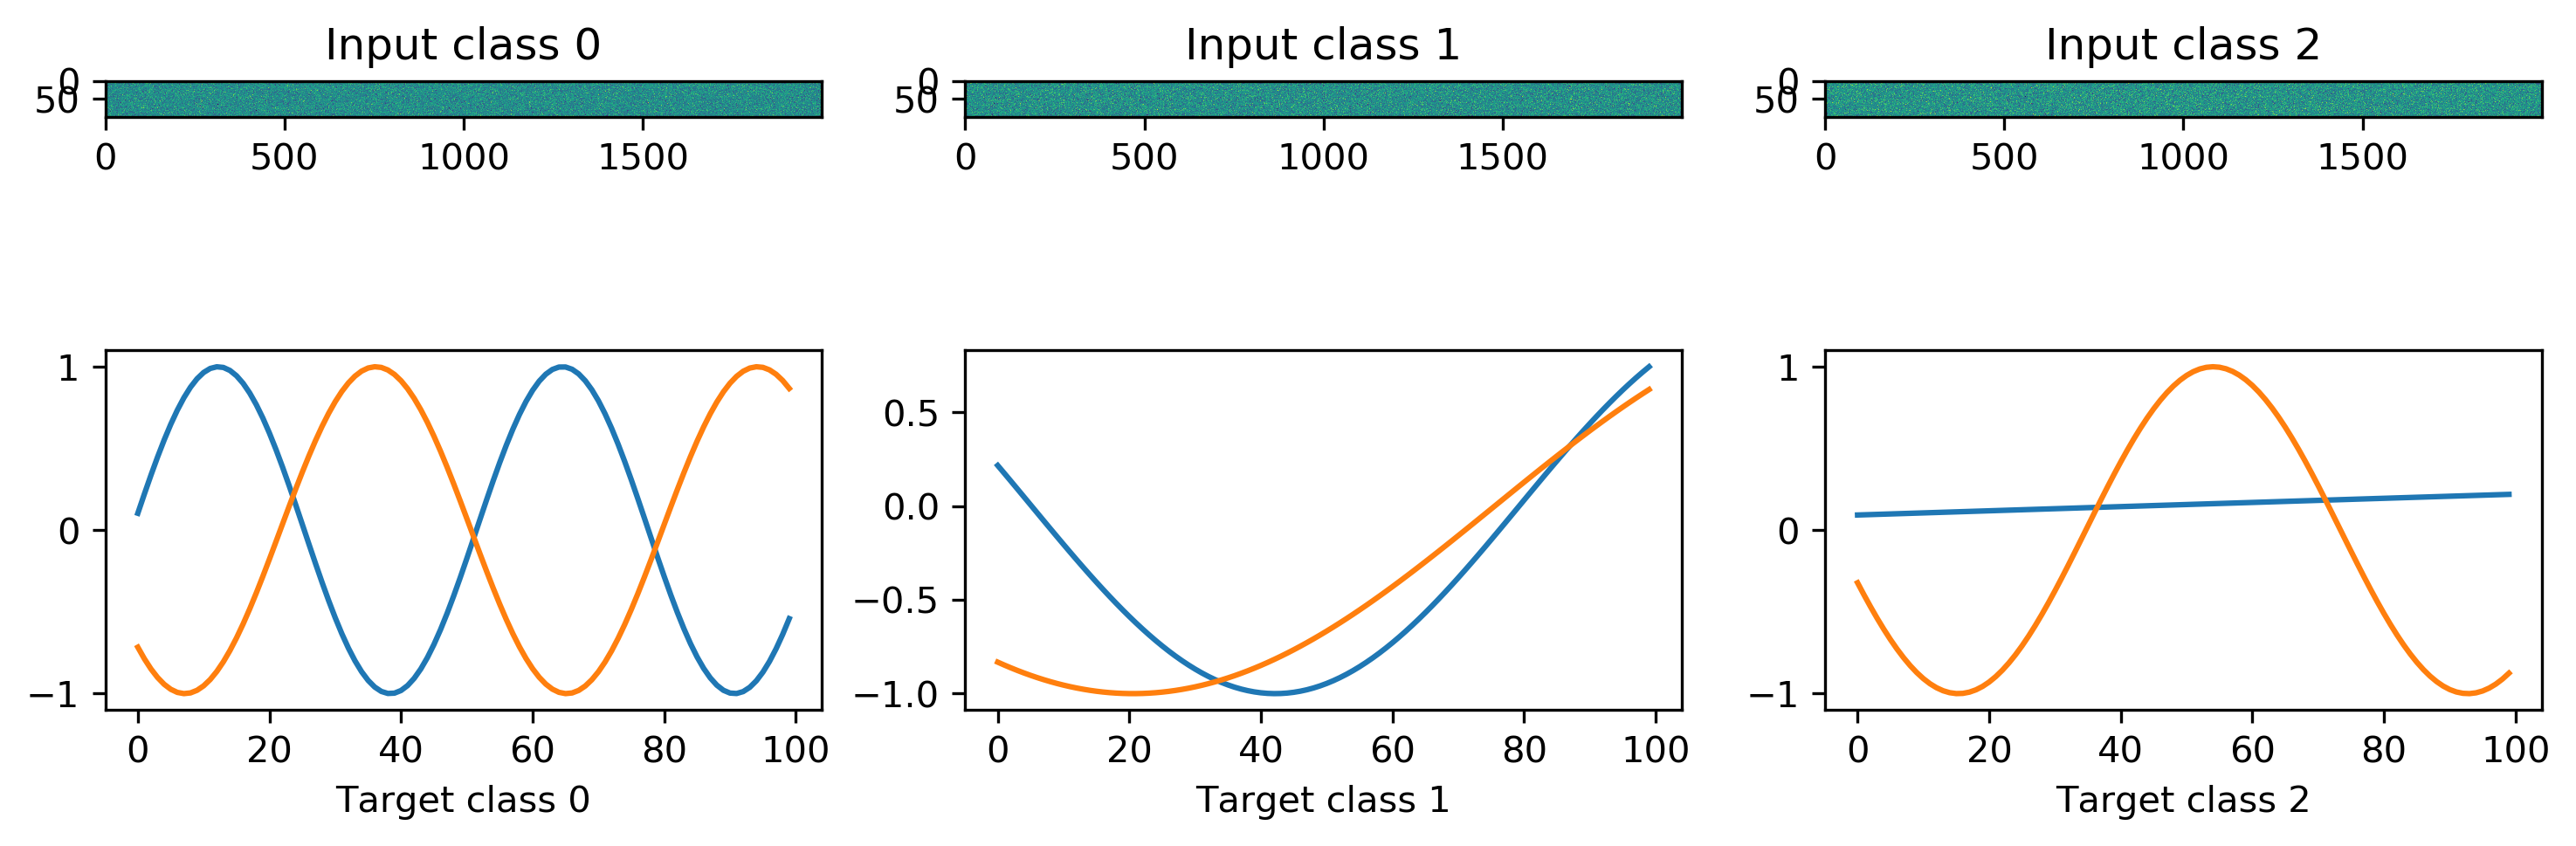

In [3]:
# - Instantiate a dataset
Nin = 2000
Nout = 2
num_classes = 3
T = 100
ds = MultiClassRandomSinMapping(num_classes = num_classes,
                                input_channels = Nin,
                                target_channels = Nout,
                                sample_length = T,
                               )

# Display the dataset classes
plt.figure()
for i, sample in enumerate(ds):
    plt.subplot(2, len(ds), i + 1)
    plt.imshow(sample[0])
    plt.title(f'Input class {i}')
    
    plt.subplot(2, len(ds), i + len(ds) + 1)
    plt.plot(sample[1])
    plt.xlabel(f'Target class {i}')

## Defining a network

In [4]:
from torch.nn import Linear, Tanh
from rockpool.nn.modules.torch.torch_module import TorchModule
import copy

class SimpleNet(TorchModule):
    def __init__(self,
                 Nin,
                 Nhidden,
                 Nout):
        super().__init__()
        self.lin_in = Linear(Nin, Nhidden, bias = False)
        self.tanh = Tanh()
        self.lin_out = Linear(Nhidden, Nout, bias = False)
        
    def forward(self, inp):
        out = self.lin_out(self.tanh(self.lin_in(inp)))
        return out

In [5]:
Nhidden = 8
net = SimpleNet(Nin, Nhidden, Nout)

## Training loop

In [6]:
# - Useful imports
from tqdm.autonotebook import tqdm
from torch.optim import Adam, SGD
from torch.nn import MSELoss

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-4)

# - Loss function
loss_fun = MSELoss()

# - Record the loss values over training iterations
loss_t = []

num_epochs = 800

# - Loop over iterations
for _ in tqdm(range(num_epochs)):
    for input, target in ds:

        optimizer.zero_grad()
                
        output, state, recordings = net(input)
        
        loss = loss_fun(output, target)
        loss.backward()
        optimizer.step()
               
        # - Keep track of the loss
        loss_t.append(loss.item())

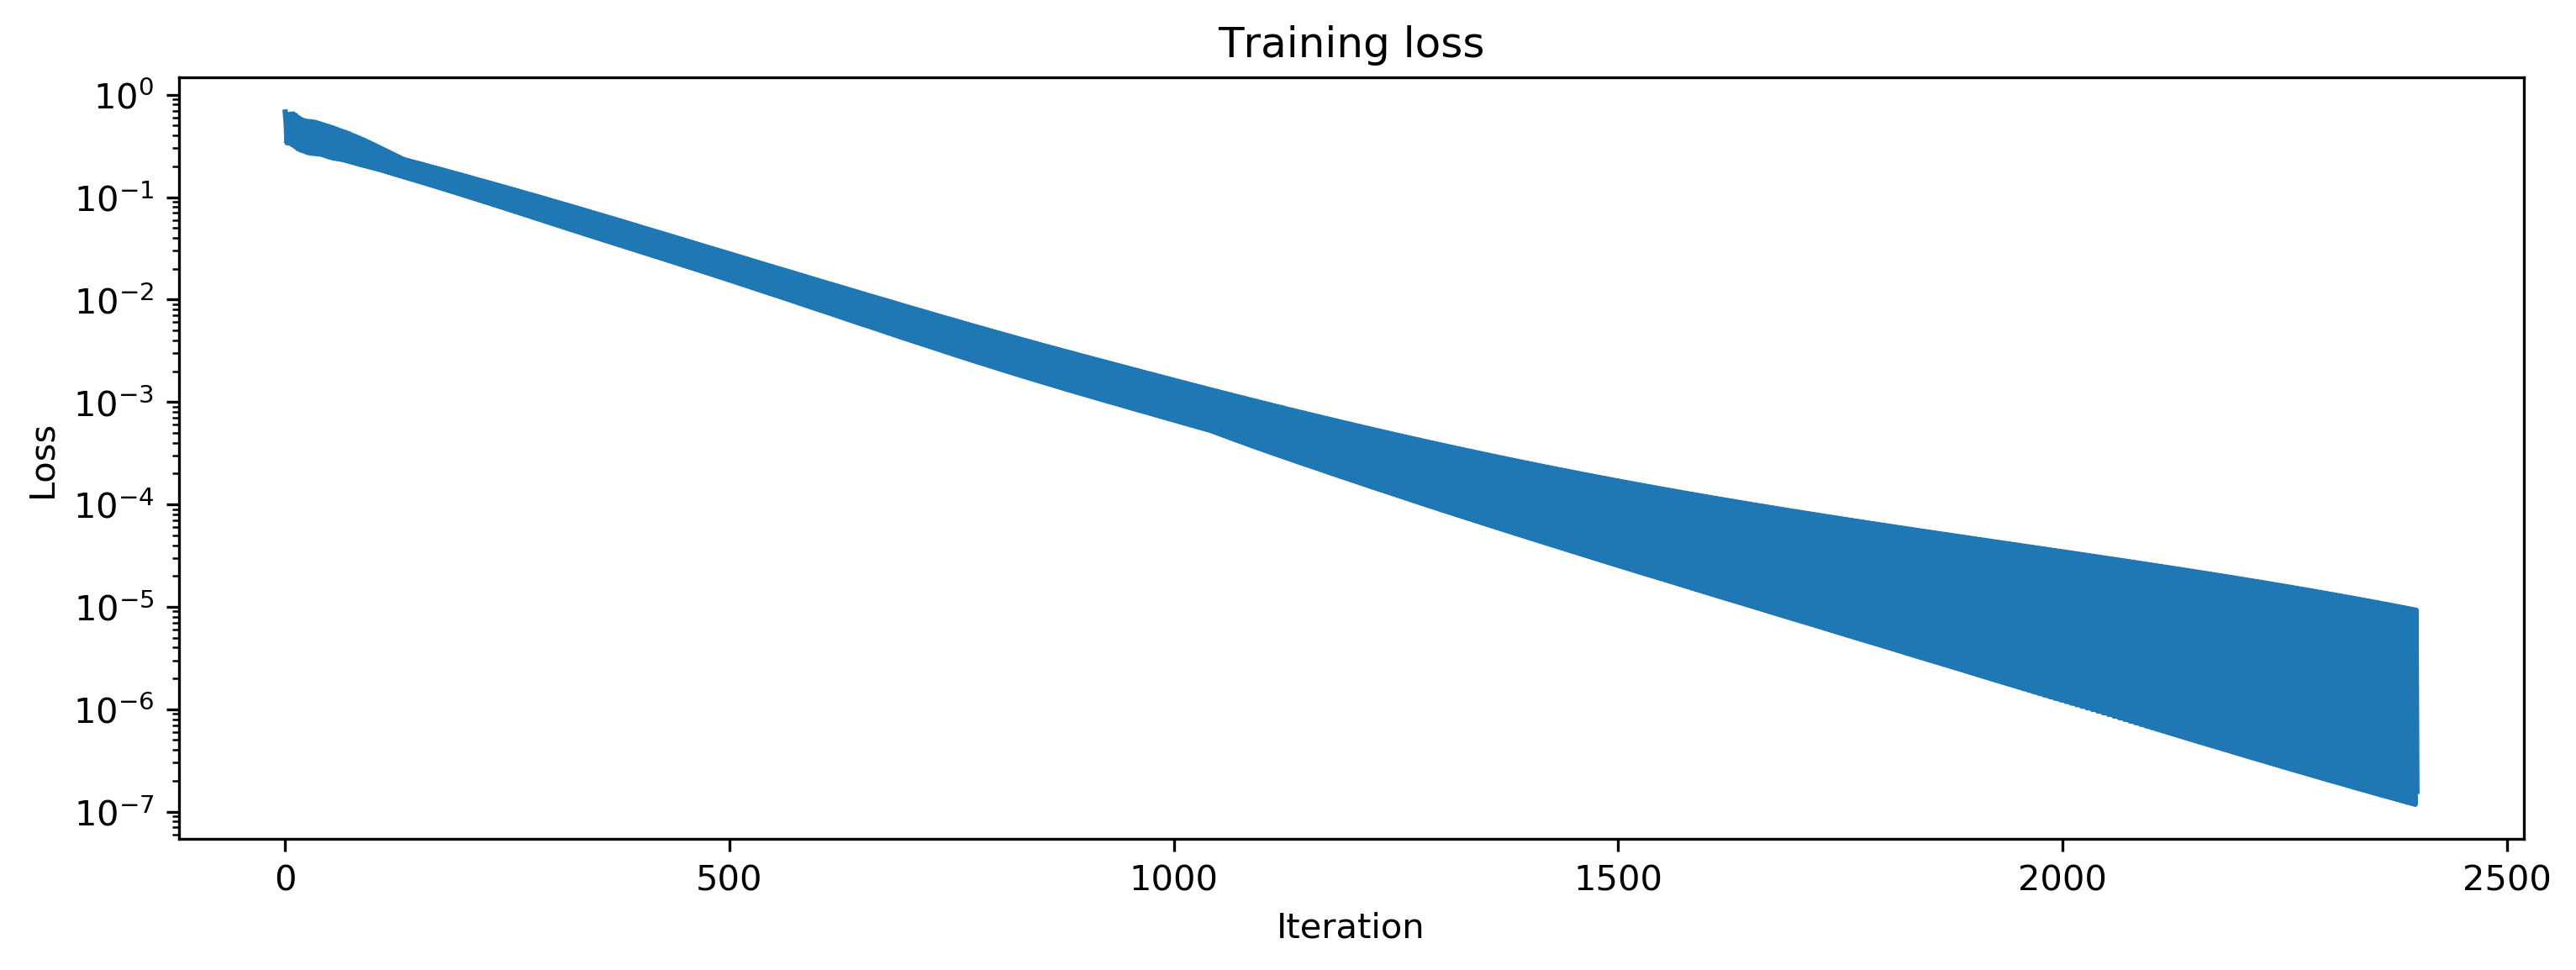

In [7]:
# - Plot the loss over iterations
plt.plot(loss_t)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss');

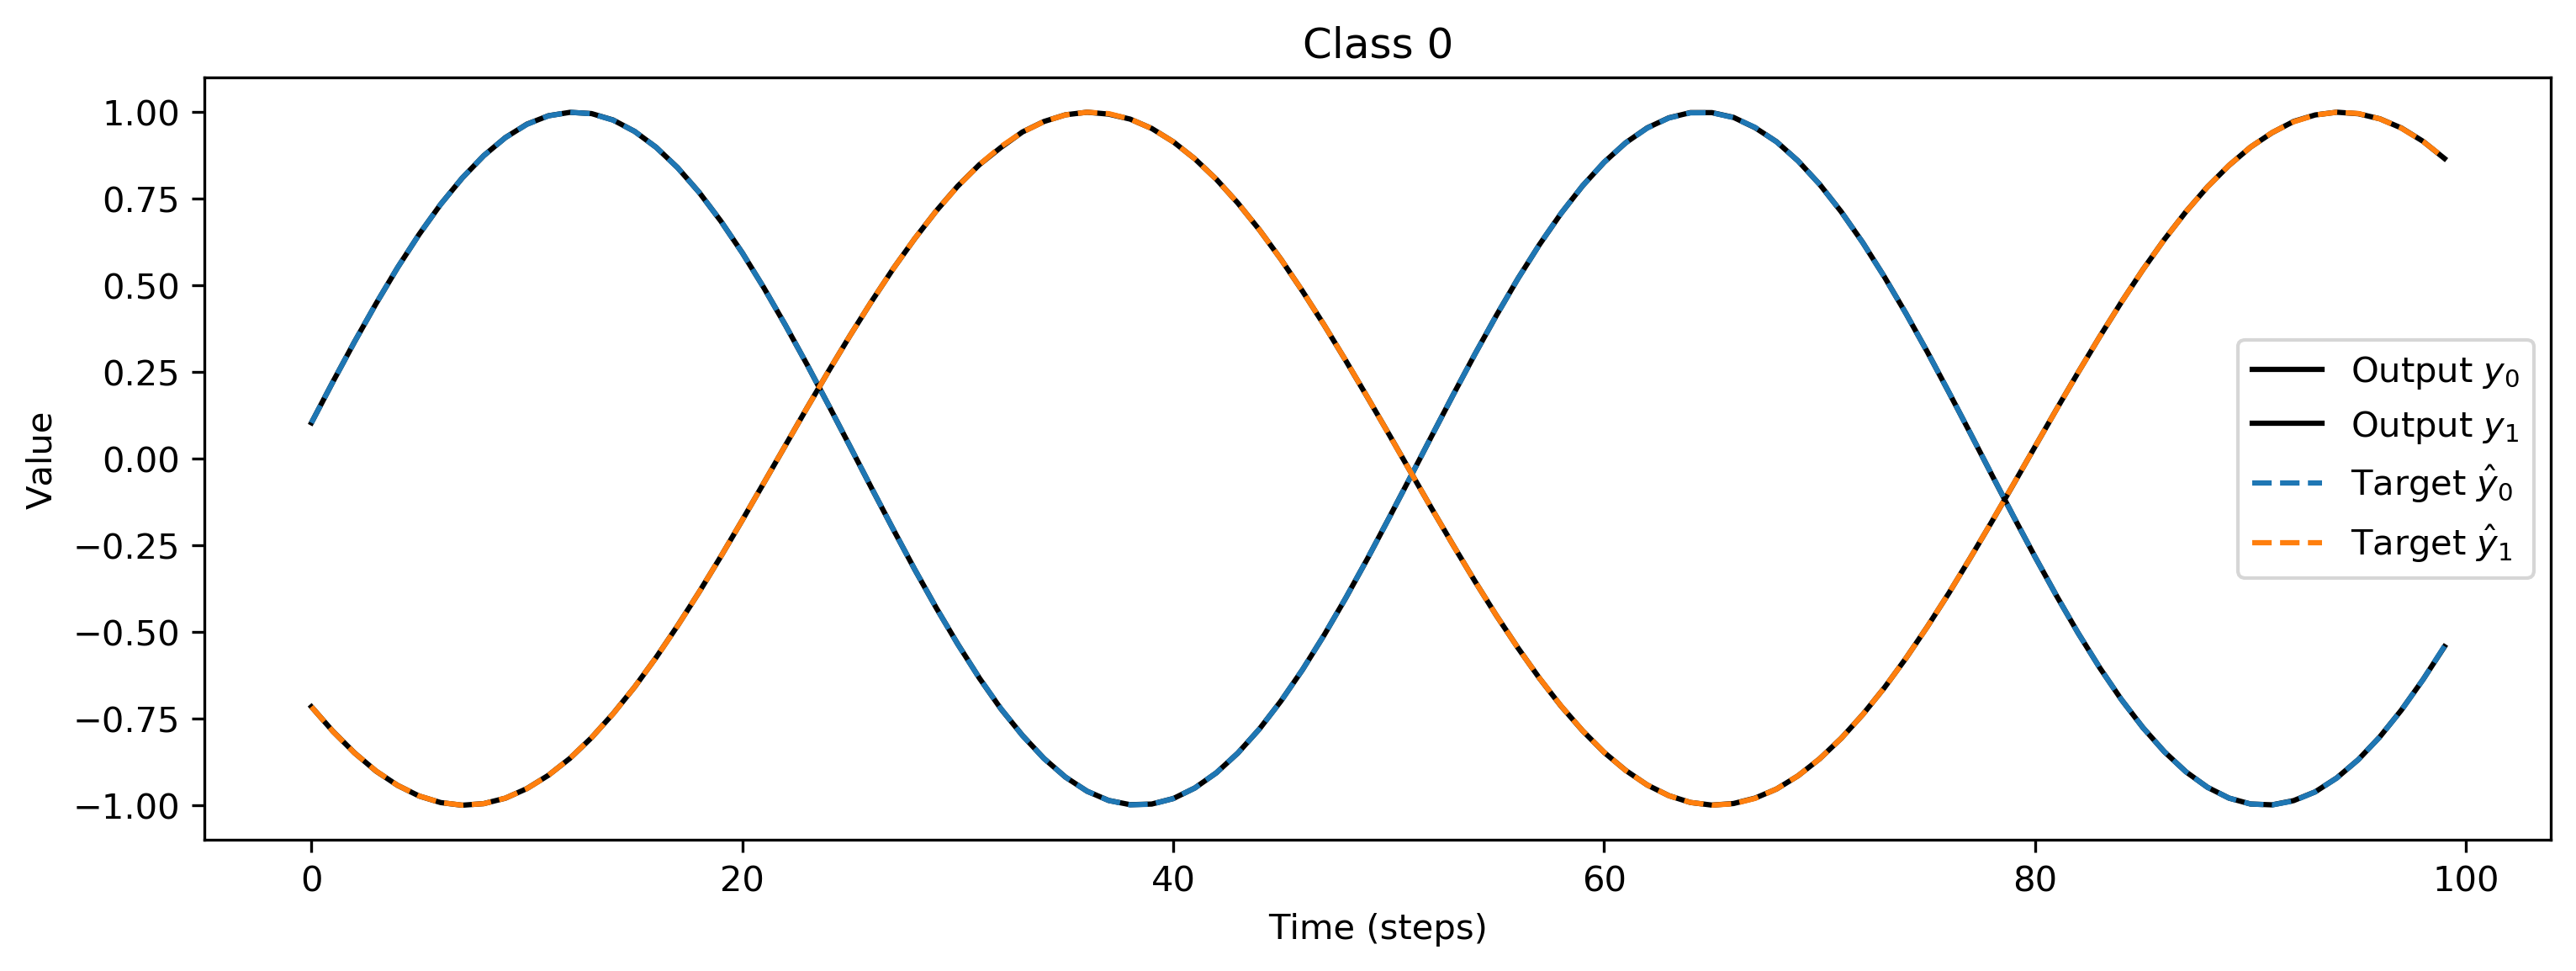

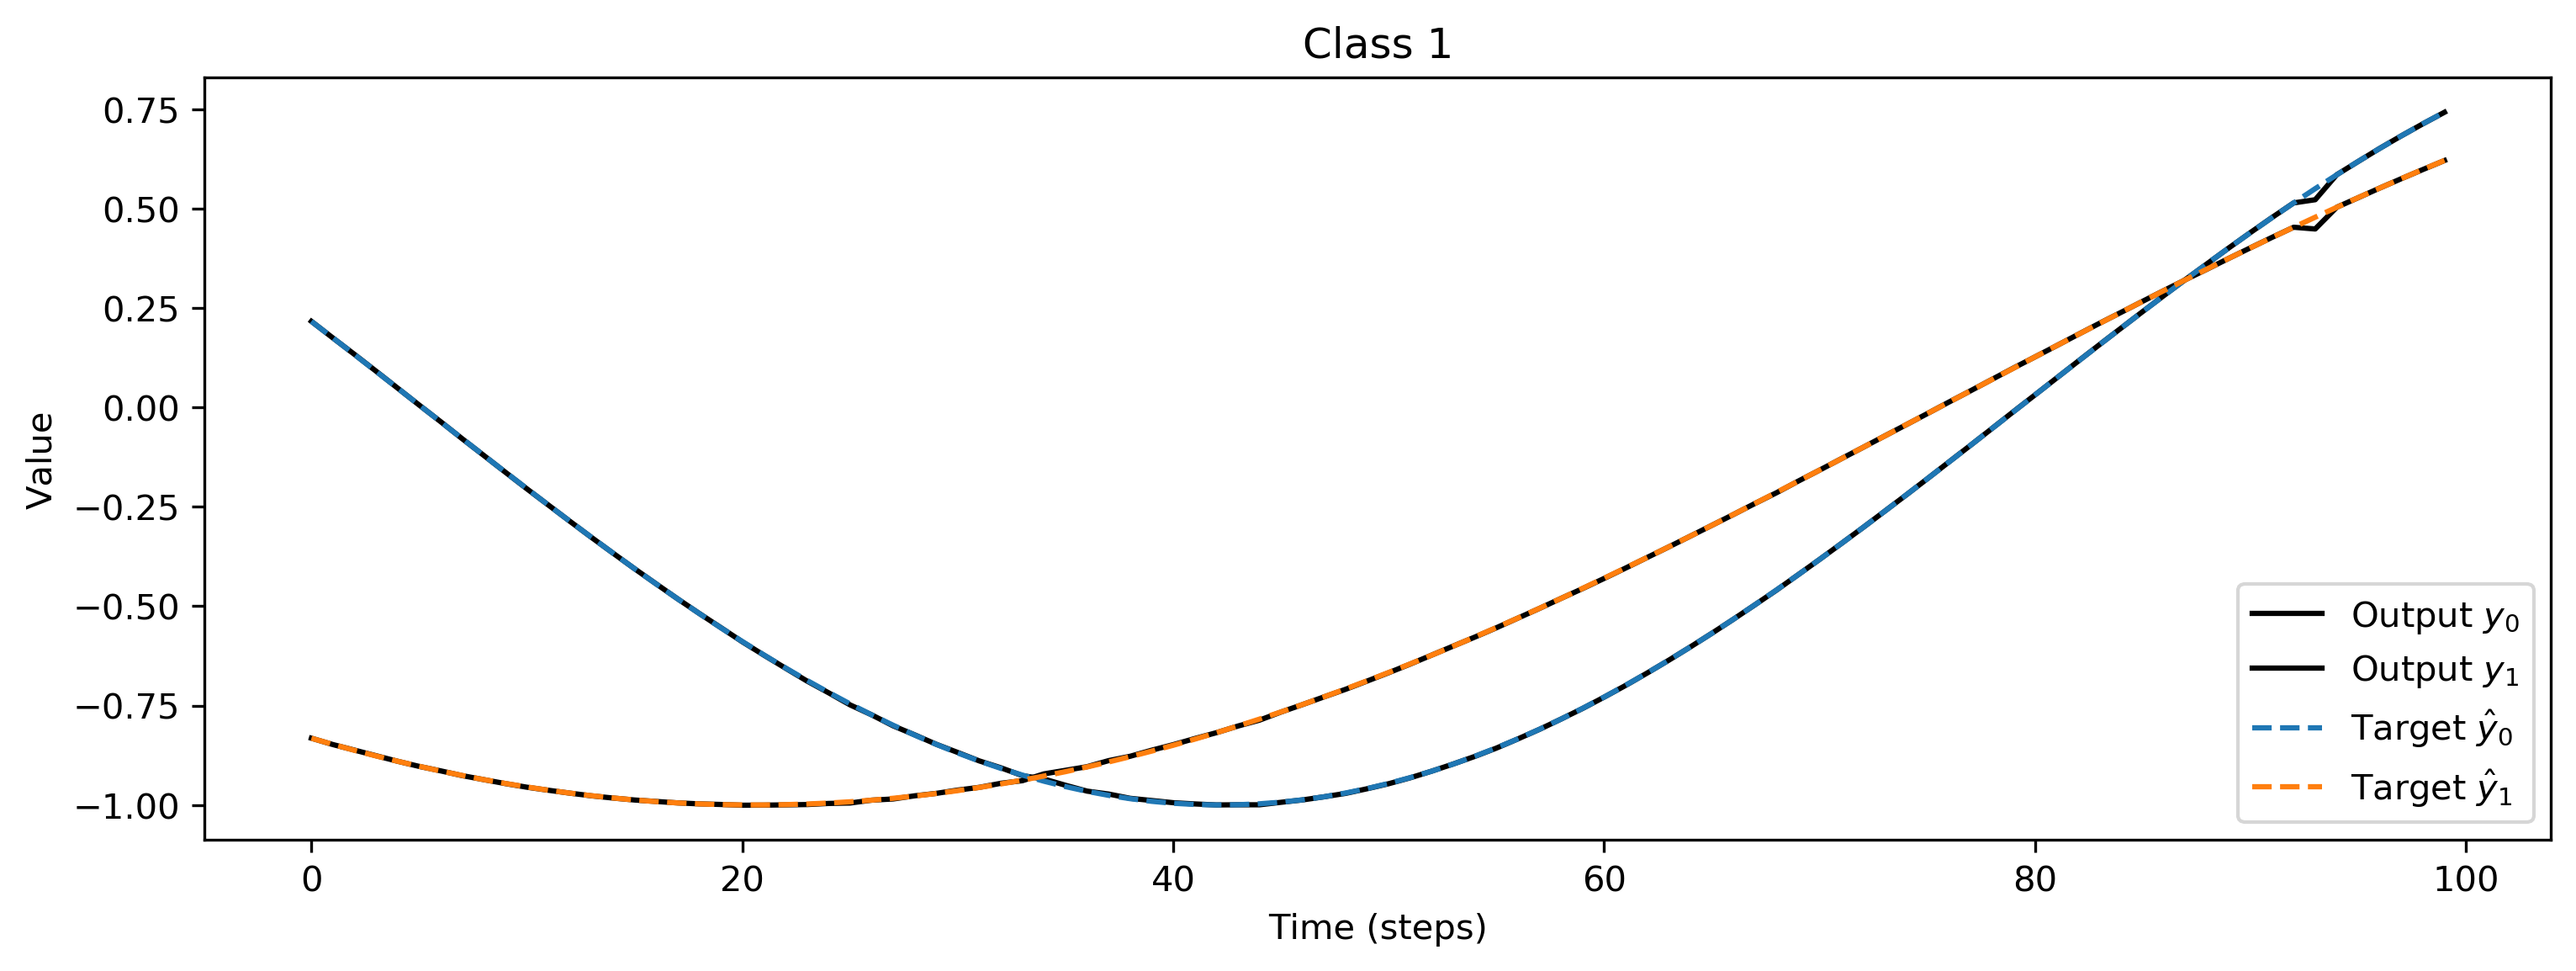

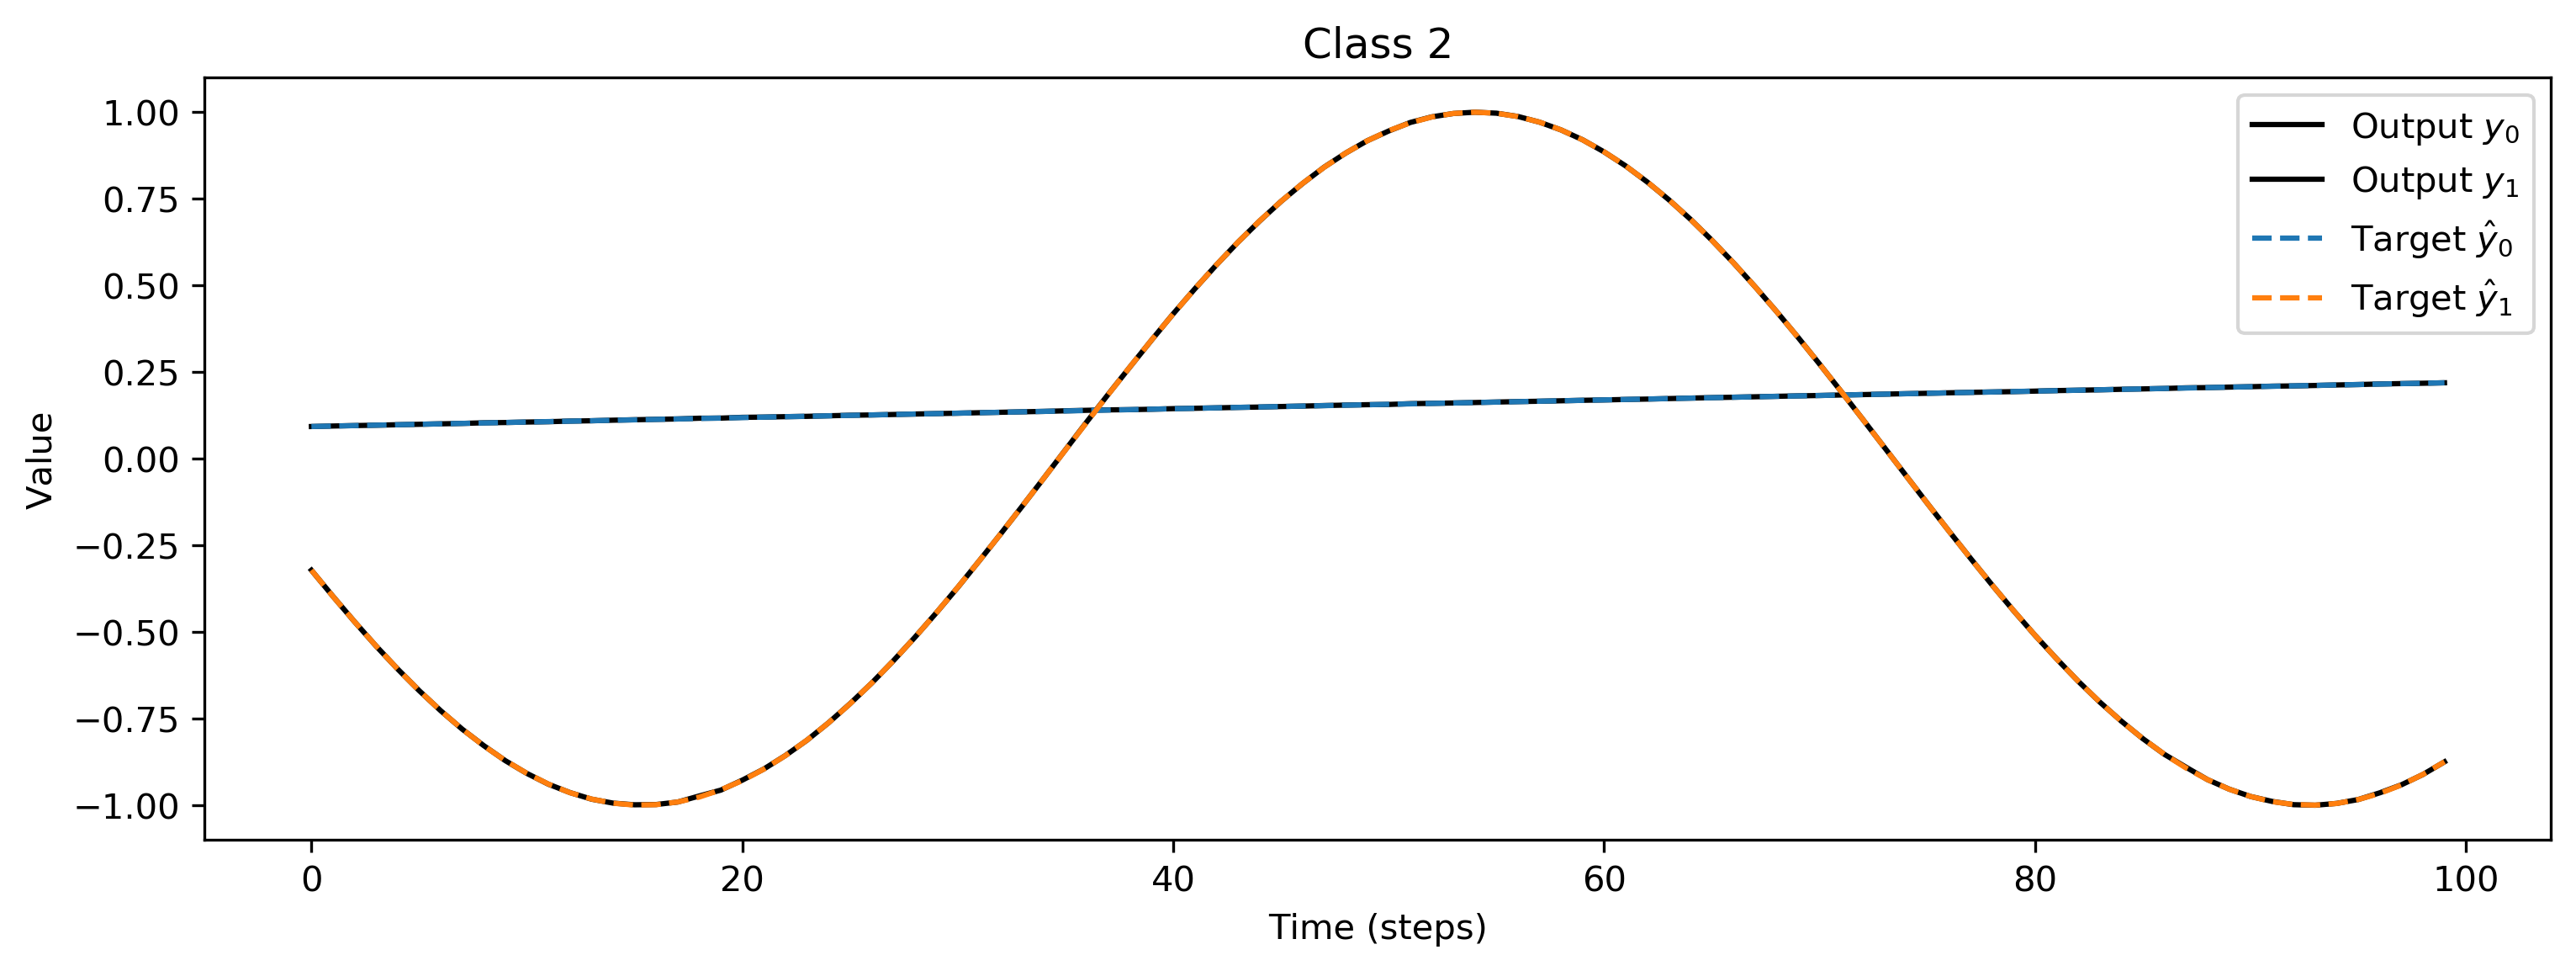

In [8]:
# - Evaluate classes
for i_class, [input, target] in enumerate(ds):
    
    # - Evaluate network
    net = net.reset_state()
    output, _, _ = net(input, record = True)
    
    # - Plot output and target
    plt.figure()
    plt.plot(output.detach().cpu().numpy(), 'k-')
    plt.plot(target, '--')
    plt.xlabel('Time (steps)')
    plt.ylabel('Value')
    plt.legend(['Output $y_0$',
                'Output $y_1$',
                'Target $\hat{y}_0$',
                'Target $\hat{y}_1$',
               ])
    plt.title(f'Class {i_class}')